# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel

import seaborn as sns
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
print(d.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  352 non-null    float64
 1   weight  352 non-null    float64
 2   age     352 non-null    float64
 3   male    352 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.8 KB
None


## Task 1. Prior predictive checks

In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [5]:
df = sim.draws_pd()
df

,lp__,accept_stat__,mi,sigma,height
0,0.0,0.0,170.416,15.7772,150.344
1,0.0,0.0,165.255,13.6106,168.606
2,0.0,0.0,167.397,17.2653,184.159
3,0.0,0.0,166.111,15.5989,165.767
4,0.0,0.0,167.624,14.6579,163.064
...,...,...,...,...,...
995,0.0,0.0,164.946,15.5211,177.124
996,0.0,0.0,164.188,13.8066,167.968
997,0.0,0.0,163.727,14.8988,164.788
998,0.0,0.0,165.018,15.2480,141.740


### 1. Plot histograms of mu, sigma and simulated height.


Text(0.5, 1.0, 'mu')

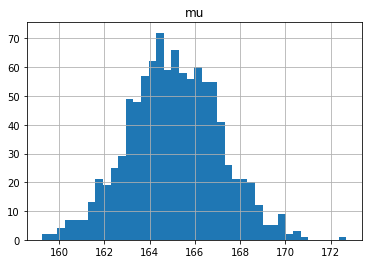

In [7]:
df['mi'].hist(bins=40)
plt.title('mu')

Text(0.5, 1.0, 'sigma')

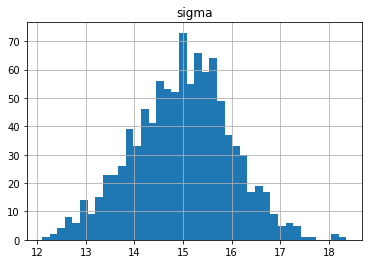

In [8]:
df['sigma'].hist(bins=40)
plt.title('sigma')

Text(0.5, 1.0, 'height')

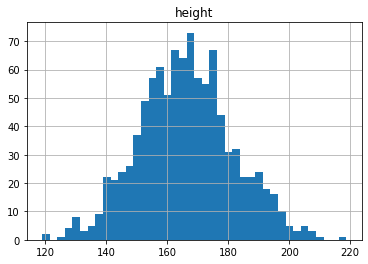

In [9]:
df['height'].hist(bins=40)
plt.title('height')



1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

#### 2. Plot a joint distribution of mu and sigma.

In [10]:
df2 = pd.DataFrame({'mi':df['mi'], 'sigma':df['sigma']})

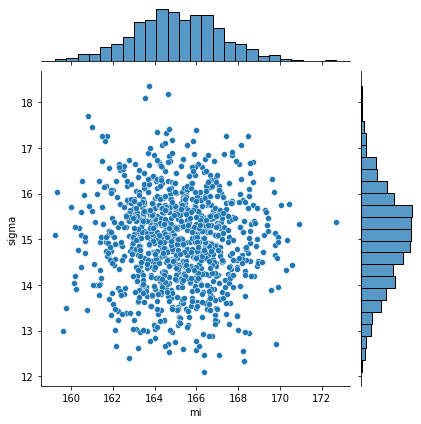

In [11]:
sns.jointplot(data=df2, x='mi', y='sigma')

#### 3. Check if samples are consistent with priors.

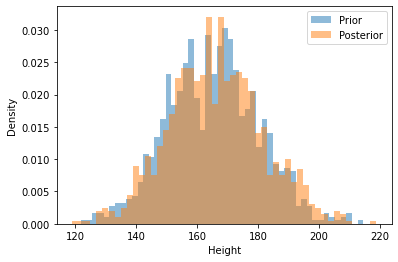

In [12]:
mi_prior = 165
sigma_prior = 15
height_prior = np.random.normal(mi_prior, sigma_prior, size=R)

# Plot the prior and posterior distributions of 'height'
fig, ax = plt.subplots()
ax.hist(height_prior, bins=50, alpha=0.5, density=True, label='Prior')
ax.hist(df['height'], bins=50, alpha=0.5, density=True, label='Posterior')
ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.legend()
plt.show()



#### 4. Correct prior parameters to make them reasonably spreaded out. - change stan file in line sigma to 50 ex

#### 5. Check if observed data is possible to obtain using priors.

In [13]:
from scipy.stats import norm
height_sim = df['height']

# Calculated the mean and standard deviation of the simulated data
height_mean_sim = np.mean(height_sim)
height_std_sim = np.std(height_sim)

# Compared the observed data to the simulated data
observed_height = 170 
z_score = (observed_height - height_mean_sim) / height_std_sim
p_value = 2 * (1 - norm.cdf(abs(z_score))) # using a two-tailed test

# Results
print(f"Z-score: {z_score:.2f}")
print(f"P-value: {p_value:.4f}")
# p-value is high and that indicates that observed data is consistent with the model's priors
#z-score  positive value indicates that the observed data is higher than the mean of the simulated data

Z-score: 0.25
P-value: 0.8019


## Task 2. Model fit and evaluation

In [13]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [15]:
df3 = fit.draws_pd()
df3

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mi,sigma,height_sample
0,-922.270,0.803033,1.217330,2.0,3.0,0.0,922.649,155.504,8.31380,165.897
1,-921.741,1.000000,1.217330,2.0,3.0,0.0,922.852,155.106,7.98469,144.761
2,-922.278,0.777707,1.217330,2.0,3.0,0.0,923.466,154.606,9.17593,159.954
3,-923.222,0.807639,1.217330,2.0,3.0,0.0,924.645,153.739,7.95915,153.032
4,-921.218,1.000000,1.217330,2.0,3.0,0.0,922.800,154.574,7.94528,164.194
...,...,...,...,...,...,...,...,...,...,...
3995,-920.191,0.986629,0.966238,2.0,3.0,0.0,920.359,154.524,8.50789,144.429
3996,-920.169,0.939478,0.966238,2.0,3.0,0.0,920.646,154.678,8.37679,151.527
3997,-920.343,0.948138,0.966238,1.0,3.0,0.0,920.469,154.638,8.63952,160.523
3998,-921.354,0.818350,0.966238,2.0,3.0,0.0,921.754,154.058,8.78571,162.261



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


#### 1. Plot a joint distribution of fitted mu and sigma.

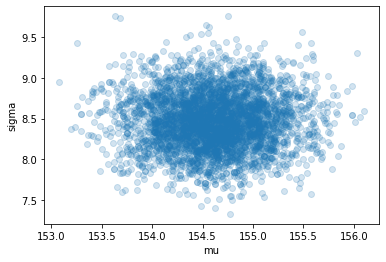

In [16]:
plt.scatter(df3['mi'], df3['sigma'], alpha=0.2)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.show()

#### 2. Plot histograms of data and simulated heights and evaluate the quality of model.


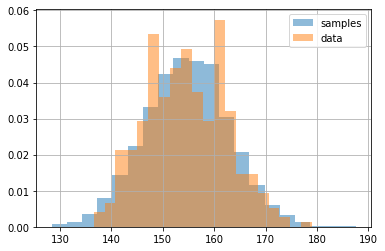

In [17]:
df3['height_sample'].hist(alpha = 0.5, bins=20, density=True, label ="samples")
d['height'].hist(alpha = 0.5, bins =20, density=True, label="data")
plt.legend()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [18]:
d['c_weight']= d['weight']- d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [26]:
model_ppc=CmdStanModel(stan_file='height_2a_pcc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/lab4/height_2a_pcc.stan to exe file /home/lab4/height_2a_pcc
INFO:cmdstanpy:compiled model executable: /home/lab4/height_2a_pcc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [29]:
df4 = sim.draws_pd()
df4

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,192.082,0.777181,13.7277,183.0150,162.696,185.656,199.239,214.387,...,217.478,227.869,223.661,206.603,184.562,196.655,200.818,215.545,209.483,214.908
1,0.0,0.0,153.011,-0.006780,14.9963,171.3240,164.491,164.189,170.759,171.281,...,193.014,152.558,139.421,150.564,138.625,160.637,137.288,151.401,172.455,151.751
2,0.0,0.0,160.730,-1.138640,13.7781,196.0960,173.244,172.887,182.692,179.040,...,171.003,127.904,166.276,149.315,170.922,143.336,156.167,147.903,140.425,143.174
3,0.0,0.0,155.179,-0.254452,14.4921,177.9810,148.993,155.232,144.407,154.860,...,160.185,154.169,157.436,172.388,145.054,144.315,164.032,143.990,156.643,145.433
4,0.0,0.0,155.066,1.671020,14.2973,94.4861,124.439,122.776,124.009,154.668,...,197.827,195.181,167.079,181.168,177.738,174.348,174.287,193.807,192.285,173.512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,156.877,1.261300,14.3942,153.5200,117.168,142.414,142.226,145.884,...,180.774,138.111,186.374,170.058,213.814,172.483,176.829,208.716,172.685,165.067
996,0.0,0.0,174.181,1.223380,15.6785,167.6620,167.721,152.202,162.443,139.058,...,181.666,198.622,198.811,164.591,206.307,186.331,161.756,215.658,190.260,193.231
997,0.0,0.0,162.396,-0.272051,12.2000,160.2400,181.275,175.545,166.926,169.176,...,151.092,153.667,166.036,136.593,159.795,168.294,144.172,161.412,148.015,151.573
998,0.0,0.0,139.058,0.987160,13.7746,137.6250,129.272,124.074,134.883,145.390,...,147.033,148.879,126.317,141.220,168.918,151.268,170.795,140.654,137.202,159.794


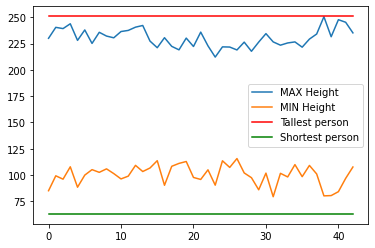

In [32]:
max_=[]
min_=[]
for i in range(1,44):
    name = "height[{a}]".format(a=i)
    max_.append(df4[name].max())
    min_.append(df4[name].min())

plt.plot(max_, label='MAX Height')
plt.plot(min_, label='MIN Height')
plt.plot([251] * len(max_), label='Tallest person', color='red')
plt.plot([63] * len(min_), label='Shortest person', color='green')
plt.legend()
plt.show()
    

Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [33]:
model_ppc=CmdStanModel(stan_file='height_2b_pcc.stan')

INFO:cmdstanpy:compiling stan file /home/lab4/height_2b_pcc.stan to exe file /home/lab4/height_2b_pcc
INFO:cmdstanpy:compiled model executable: /home/lab4/height_2b_pcc


In [34]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [35]:
df5 = sim.draws_pd()
df5

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,192.082,2.175330,13.7277,163.5540,144.1460,168.0160,182.5100,198.569,...,234.450,245.752,242.455,226.307,205.177,218.181,223.255,238.893,233.742,240.078
1,0.0,0.0,153.011,0.993243,14.9963,157.4040,151.2230,151.5720,158.7940,159.967,...,205.153,165.349,152.863,164.657,153.370,176.034,153.336,168.101,189.806,169.753
2,0.0,0.0,160.730,0.320255,13.7781,175.7890,153.8880,154.4810,165.2360,162.535,...,188.713,146.564,185.886,169.876,192.433,165.798,179.579,172.265,165.738,169.437
3,0.0,0.0,155.179,0.775342,14.4921,163.6470,135.3300,142.2400,132.0850,143.209,...,172.685,167.340,171.279,186.901,160.238,160.170,180.558,161.187,174.510,163.972
4,0.0,0.0,155.066,5.317560,14.2973,43.7283,76.0566,76.7689,80.3774,113.412,...,242.092,241.821,216.095,232.560,231.506,230.491,232.806,254.701,255.555,239.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,156.877,3.529990,14.3942,121.9410,87.0673,113.7910,115.0810,120.217,...,208.313,167.129,216.870,202.032,247.266,207.412,213.236,246.602,212.048,205.908
996,0.0,0.0,174.181,3.398650,15.6785,137.3840,138.8600,124.7580,136.4160,114.448,...,208.072,226.445,228.050,195.248,238.381,219.822,196.664,251.983,228.003,232.390
997,0.0,0.0,162.396,0.761815,12.2000,145.8490,167.5580,162.5010,154.5560,157.480,...,163.642,166.891,179.933,151.164,175.039,184.212,160.763,178.677,165.953,170.185
998,0.0,0.0,139.058,2.683600,13.7746,114.0120,106.7640,102.6700,114.5850,126.198,...,167.626,170.578,149.120,165.129,193.932,177.387,198.019,168.983,166.636,190.334


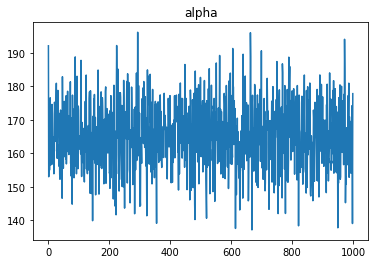

In [38]:
# 1.
plt.plot(df5['alpha'])
plt.title("alpha")
plt.show()

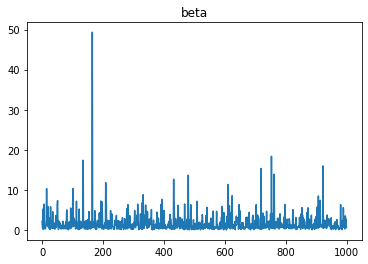

In [39]:
# 1.
plt.plot(df5['beta'])
plt.title("beta")
plt.show()

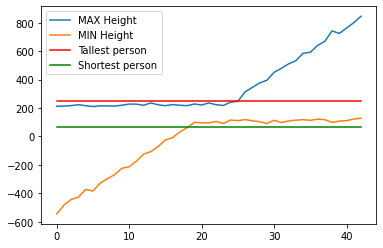

In [36]:
#1
max_=[]
min_=[]
for i in range(1,44):
    name = "height[{a}]".format(a=i)
    max_.append(df5[name].max())
    min_.append(df5[name].min())

plt.plot(max_, label='MAX Height')
plt.plot(min_, label='MIN Height')
plt.plot([251] * len(max_), label='Tallest person', color='red')
plt.plot([63] * len(min_), label='Shortest person', color='green')
plt.legend()
plt.show()

1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

## Task 6. Fitting and evaluating model


In [41]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/lab4/height_2_fit.stan to exe file /home/lab4/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/lab4/height_2_fit


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [44]:
N = 100
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [45]:
df6 = fit.draws_pd()
df6

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,h_hat[91],h_hat[92],h_hat[93],h_hat[94],h_hat[95],h_hat[96],h_hat[97],h_hat[98],h_hat[99],h_hat[100]
0,-267.392,0.856483,0.133023,5.0,31.0,0.0,269.784,124.846,8.90091,0.667156,...,155.374,143.077,139.917,161.359,161.428,154.731,148.849,163.081,159.741,158.163
1,-268.740,0.981101,0.133023,3.0,15.0,0.0,269.417,121.915,9.97583,0.718784,...,153.167,156.946,143.039,164.745,160.010,165.853,139.592,145.802,171.879,142.481
2,-269.137,0.996772,0.133023,4.0,31.0,0.0,270.810,126.231,10.49870,0.623105,...,169.875,134.910,156.968,172.588,135.898,156.115,153.637,157.516,146.261,147.147
3,-267.621,0.998276,0.133023,4.0,15.0,0.0,269.494,123.794,9.31588,0.685893,...,153.835,148.918,166.737,151.126,158.593,158.905,153.905,164.055,157.937,148.605
4,-267.685,0.982877,0.133023,5.0,31.0,0.0,268.033,122.474,7.81962,0.709250,...,153.044,161.527,150.780,150.992,155.029,176.828,147.470,157.331,148.599,147.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-267.822,0.912076,0.125279,4.0,17.0,0.0,268.569,125.985,8.54950,0.612396,...,156.606,153.980,160.431,162.706,156.850,157.302,150.991,158.240,153.975,161.736
3996,-267.954,0.884447,0.125279,4.0,31.0,0.0,270.039,119.803,7.81566,0.758741,...,145.616,153.441,154.063,154.716,174.028,159.488,144.917,154.600,159.748,159.157
3997,-269.435,0.847055,0.125279,5.0,31.0,0.0,269.949,117.354,8.04239,0.845913,...,165.873,170.516,154.639,147.573,165.348,167.500,144.246,162.273,161.510,143.186
3998,-268.259,0.800145,0.125279,2.0,3.0,0.0,271.211,117.507,7.96826,0.809452,...,163.159,162.416,152.784,167.758,147.485,167.315,133.424,162.738,160.691,156.418


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


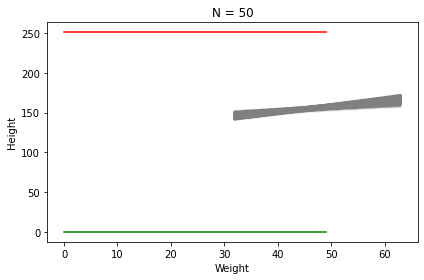

In [51]:

N = 50
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


alpha_samples = df6['alpha'].values
beta_samples = df6['beta'].values

for i in range(len(alpha_samples)):
    plt.plot(data_fit['weights'], beta_samples[i] * data_fit['weights'] + alpha_samples[i], 'gray', alpha=0.1)

plt.plot([251] * len(data_fit['weights']), label='Tallest person', color='red')
plt.plot([0] * len(data_fit['weights']), label='Shortest person', color='green')

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)





chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


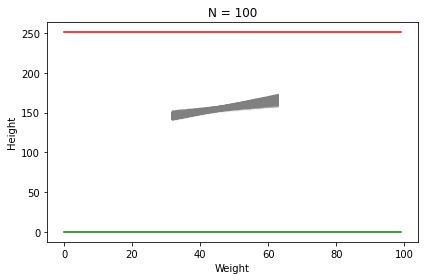

In [52]:
N = 100
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


alpha_samples = df6['alpha'].values
beta_samples = df6['beta'].values

for i in range(len(alpha_samples)):
    plt.plot(data_fit['weights'], beta_samples[i] * data_fit['weights'] + alpha_samples[i], 'gray', alpha=0.1)

plt.plot([251] * len(data_fit['weights']), label='Tallest person', color='red')
plt.plot([0] * len(data_fit['weights']), label='Shortest person', color='green')

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

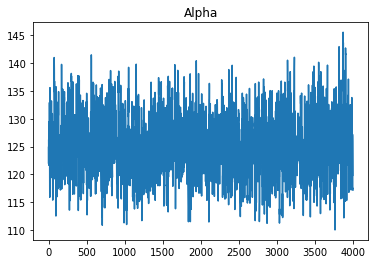

In [55]:

plt.plot(df6['alpha'])
plt.title(f'Alpha')
plt.show()



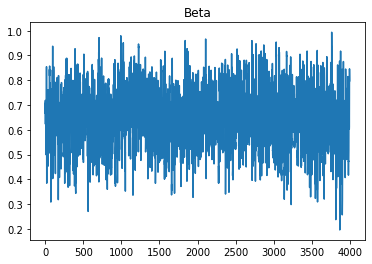

In [56]:
plt.plot(df6['beta'])
plt.title(f'Beta')
plt.show()

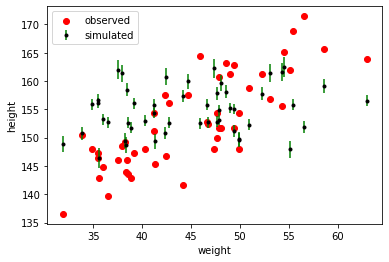

In [64]:

observed_heights = d['height'].head(50)
weights = d['weight'].head(50)
heights = df6.iloc[:,60:110]
std = heights.std()[:50]
mean = heights.mean()[:50]

plt.figure(16)
plt.errorbar(weights, mean, std, fmt="k.", ecolor="green", label="simulated")
plt.scatter(weights, observed_heights, color="red", label="observed")
plt.xlabel(f'weight')
plt.ylabel(f'height')
plt.legend(loc='best')
plt.show()

## Task 7. Extending the model



In [66]:
N = 50
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)



INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [67]:
df7 = fit.draws_pd()
df7

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,h_hat[41],h_hat[42],h_hat[43],h_hat[44],h_hat[45],h_hat[46],h_hat[47],h_hat[48],h_hat[49],h_hat[50]
0,-142.359,0.724724,0.193319,2.0,3.0,0.0,146.002,140.086,11.8084,0.213543,...,145.696,151.604,155.575,149.833,147.240,147.322,148.301,154.858,131.989,158.183
1,-142.679,1.000000,0.193319,3.0,11.0,0.0,143.177,146.611,11.6708,0.238493,...,156.935,144.989,149.868,157.731,175.414,151.230,170.974,144.103,174.785,169.250
2,-140.223,0.905357,0.193319,4.0,27.0,0.0,144.976,141.216,11.0259,0.289445,...,155.354,166.554,144.898,152.385,175.347,164.162,145.171,159.418,162.826,145.303
3,-139.801,1.000000,0.193319,4.0,27.0,0.0,140.546,143.761,12.2411,0.208096,...,144.493,145.825,162.836,154.573,156.135,154.939,155.118,148.902,151.357,164.621
4,-140.241,0.942819,0.193319,4.0,31.0,0.0,140.798,136.116,11.6775,0.348038,...,136.677,161.523,150.801,163.132,159.373,142.164,140.969,162.026,138.509,157.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-140.723,0.928041,0.211948,4.0,23.0,0.0,143.232,146.421,13.2624,0.145827,...,148.497,155.271,148.380,182.499,157.418,159.493,149.268,160.821,153.288,163.138
3996,-141.251,0.759110,0.211948,2.0,3.0,0.0,143.425,146.244,13.7153,0.146769,...,141.910,137.619,127.147,152.479,142.458,116.540,164.992,171.298,148.612,170.194
3997,-141.206,0.987996,0.211948,2.0,3.0,0.0,141.569,147.470,13.6857,0.148791,...,130.068,146.882,173.832,159.656,163.046,161.688,126.890,149.844,151.184,157.728
3998,-142.152,0.738771,0.211948,2.0,3.0,0.0,143.969,145.150,13.9584,0.140337,...,155.970,120.217,140.482,173.991,134.015,164.142,167.543,155.077,144.173,156.476


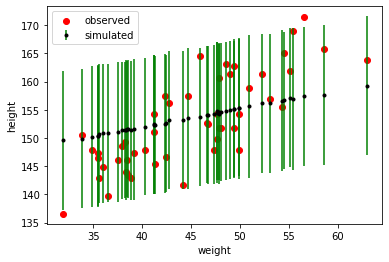

In [68]:
observed_heights = d['height'].head(50)
weights = d['weight'].head(50)
heights = df7.iloc[:,60:110]
std = heights.std()[:50]
mean = heights.mean()[:50]

plt.figure(16)
plt.errorbar(weights, mean, std, fmt="k.", ecolor="green", label="simulated")
plt.scatter(weights, observed_heights, color="red", label="observed")
plt.xlabel(f'weight')
plt.ylabel(f'height')
plt.legend(loc='best')
plt.show()